# Progressively Train Pneumonia Model using RESNET_18

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from fastai.vision import *
from fastai.callbacks import SaveModelCallback
import pandas as pd
import collections
import math

In [3]:
#from load_databunch import build_databunch

In [4]:
import numpy as np
np.random.seed(1234)
import torch
torch.manual_seed(1234)

In [5]:
import fastai_addons   #add plot2 extension -- learn.recorder.plot2()
from fastai_addons import interpretation_summary, plot_confusion_matrix, get_accuracy, \
                          analyze_confidence, accuracy_vs_threshold, show_incremental_accuracy, \
                          analyze_low_confidence, plot_confusion_matrix_thresh

## Config

In [6]:
prefix = 'resnet18_'
selected_model = models.resnet18
bs=96

In [7]:
PATH = Path('')
data_dir = PATH / 'data'
images_full = PATH / 'data' / 'chest_xray'
images_896 = PATH / 'data' / 'chest_xray_896'
images_448 = PATH / 'data' / 'chest_xray_448'
images_224 = PATH / 'data' / 'chest_xray_224'
images_112 = PATH / 'data' / 'chest_xray_112'
images_56 = PATH / 'data' / 'chest_xray_56'

model_dir = PATH / 'models'

# Code

In [8]:
def get_db(image_dir, bs=128, use_test_as_val=True):
    tfms = get_transforms(do_flip=True, flip_vert=False,
                          max_zoom=1.3, max_lighting=0.3)
    if use_test_as_val:
            data = ImageDataBunch.from_folder(image_dir, valid='val', test='test', 
                                      bs=bs, num_workers=7,
                                      ds_tfms=tfms).normalize(imagenet_stats)
    else:
        data = ImageDataBunch.from_folder(image_dir, valid='test', test='val', 
                                          bs=bs, num_workers=7,
                                          ds_tfms=tfms).normalize(imagenet_stats)
    return data

# Calibrate Block Size

In [10]:
for bs in [8, 12, 16, 24, 32]:
    data = get_db(images_896, bs)
    learn = cnn_learner(data, selected_model, metrics=error_rate).to_fp16().mixup()
    learn.unfreeze()
    learn.fit(1)

epoch,train_loss,valid_loss,error_rate,time
0,0.505378,1.451947,0.500000,02:49


epoch,train_loss,valid_loss,error_rate,time
0,0.488455,0.976523,0.500000,02:36


epoch,train_loss,valid_loss,error_rate,time
0,0.469423,1.020593,0.562500,02:33


epoch,train_loss,valid_loss,error_rate,time
0,0.436437,1.656234,0.500000,02:33


epoch,train_loss,valid_loss,error_rate,time
0,0.436457,0.994016,0.375000,02:32


# Train Model

In [11]:
bs = 32
save_name = f'{prefix}896_frozen'

data = get_db(images_896, bs, use_test_as_val=False)
learn = cnn_learner(data, selected_model, metrics=error_rate).to_fp16().mixup()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 9.12E-03 
Min loss divided by 10: 5.75E-03
Min numerical gradient: 1.74E-03  (smoothed)
Min numerical gradient: 7.59E-03
Min loss divided by 10: 5.75E-03


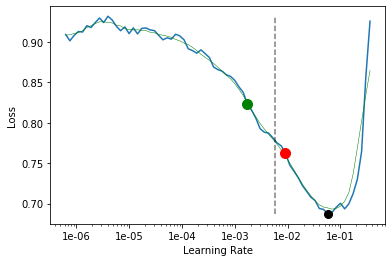

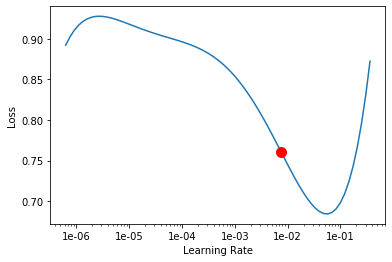

In [12]:
learn.lr_find()
learn.recorder.plot2()
learn.recorder.plot(k=5, suggestion=True)

In [13]:
learn.fit_one_cycle(16, max_lr=3e-3,
                    callbacks=[SaveModelCallback(learn, every='improvement', name=save_name)])

epoch,train_loss,valid_loss,error_rate,time
0,0.495457,0.310289,0.107372,02:47
1,0.335327,0.321092,0.105769,02:44
2,0.312884,0.275036,0.086538,02:45
3,0.277368,0.344795,0.147436,02:44
4,0.273480,0.394884,0.141026,02:44
5,0.267514,0.393652,0.139423,02:46
6,0.258019,0.427780,0.173077,02:46
7,0.261330,0.274699,0.099359,02:44
8,0.235062,0.375513,0.121795,02:46
9,0.238687,0.343395,0.120192,02:45


Better model found at epoch 0 with valid_loss value: 0.31028926372528076.
Better model found at epoch 2 with valid_loss value: 0.2750355303287506.
Better model found at epoch 7 with valid_loss value: 0.27469906210899353.


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 6.31E-07 
Min loss divided by 10: 1.32E-07
Min numerical gradient: 1.00E-03  (smoothed)
Min numerical gradient: 1.74E-03
Min loss divided by 10: 6.31E-08


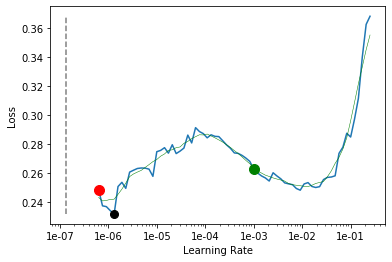

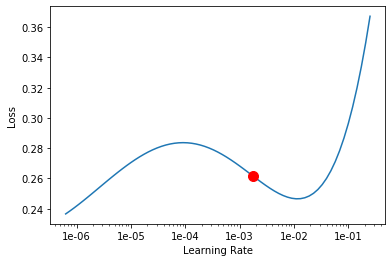

In [14]:
learn.lr_find()
learn.recorder.plot2()
learn.recorder.plot(k=5, suggestion=True)

In [15]:
learn.fit_one_cycle(16, max_lr=3e-4,
                    callbacks=[SaveModelCallback(learn, every='improvement', name=save_name)])

epoch,train_loss,valid_loss,error_rate,time
0,0.249377,0.291851,0.110577,02:44
1,0.242171,0.279756,0.105769,02:43
2,0.228404,0.295999,0.108974,02:44
3,0.232224,0.335036,0.121795,02:44
4,0.222819,0.394162,0.141026,02:46
5,0.229900,0.324394,0.115385,02:45
6,0.226213,0.344978,0.121795,02:45
7,0.227825,0.322093,0.115385,02:44
8,0.221861,0.372028,0.121795,02:44
9,0.222243,0.348962,0.120192,02:43


Better model found at epoch 0 with valid_loss value: 0.2918509244918823.
Better model found at epoch 1 with valid_loss value: 0.27975553274154663.


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 6.31E-07 
Min loss divided by 10: 1.91E-05
Min numerical gradient: 2.29E-06  (smoothed)
Min numerical gradient: 4.79E-06
Min loss divided by 10: 3.63E-06


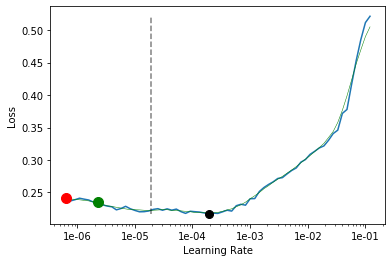

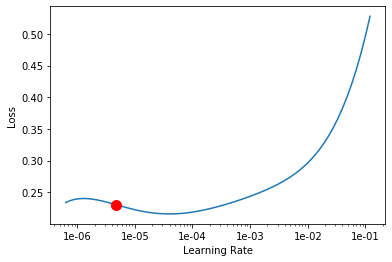

In [16]:
learn.unfreeze()
save_name = f'{prefix}896_unfrozen'
learn.lr_find()
learn.recorder.plot2()
learn.recorder.plot(k=5, suggestion=True)

In [17]:
learn.fit_one_cycle(4, max_lr=slice(2e-5),
                    callbacks=[SaveModelCallback(learn, every='improvement', name=save_name)])

epoch,train_loss,valid_loss,error_rate,time
0,0.236453,0.307332,0.118590,02:46
1,0.238187,0.299631,0.113782,02:46
2,0.232256,0.285319,0.107372,02:47
3,0.226641,0.297361,0.113782,02:47


Better model found at epoch 0 with valid_loss value: 0.307332307100296.
Better model found at epoch 1 with valid_loss value: 0.29963111877441406.
Better model found at epoch 2 with valid_loss value: 0.28531911969184875.


In [ ]:
learn.fit_one_cycle(4, max_lr=slice(2e-5),
                    callbacks=[SaveModelCallback(learn, every='improvement', name=save_name)])